In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [24]:
import torch
import pyro
from pyro.infer.autoguide import AutoMultivariateNormal, AutoIAFNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints

pyro.set_rng_seed(101)

In [25]:
nside = 128

/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


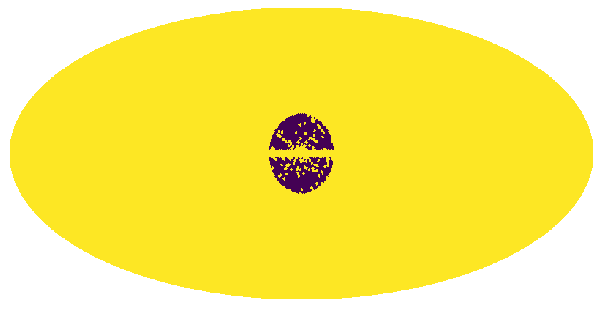

In [7]:
import sys
sys.path.append("../")

from utils import create_mask as cm

ps_mask = hp.ud_grade(np.load("../data/fermi_data/fermidata_pscmask.npy") > 0, nside_out=nside)
ps_mask = hp.ud_grade(np.load("../data/mask_3fgl_0p8deg.npy") > 0, nside_out=nside)

mask = cm.make_mask_total(nside=nside, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 20, 
                          custom_mask=ps_mask
                              )

hp.mollview(mask,title='',cbar=False,min=0,max=1)

## Inference with pyro

In [8]:
data = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/fermidata_counts.npy'), nside_out=nside, power=-2))[~mask]

temp_bub = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_bub.npy'), nside_out=nside, power=-2))[~mask]
temp_iso = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_iso.npy'), nside_out=nside, power=-2))[~mask]
temp_dif = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_dif.npy'), nside_out=nside, power=-2))[~mask]
temp_psc = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_psc.npy'), nside_out=nside, power=-2))[~mask]
temp_gce = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_gce.npy'), nside_out=nside, power=-2))[~mask]

In [9]:
def model(data):
    A_bub = pyro.sample("A_bub", dist.Uniform(0.1, 2.))
    A_iso = pyro.sample("A_iso", dist.Uniform(0.1, 2.))
    A_psc = pyro.sample("A_psc", dist.Uniform(0.1, 2.))
    A_dif = pyro.sample("A_dif", dist.Uniform(0.1, 50.))
    A_gce = pyro.sample("A_gce", dist.Uniform(0.1, 50.))
    mu = A_bub * temp_bub + A_iso * temp_iso + A_psc * temp_psc + A_dif * temp_dif + A_gce * temp_gce
    with pyro.plate("data", len(data)):
#         log_likelihood = (mu.log() * data) - mu - (data + 1).lgamma()
#         pyro.factor("obs", log_likelihood)
        return pyro.sample("obs", dist.Poisson(mu), obs=data)

In [26]:
guide = AutoIAFNormal(model)

In [27]:
svi = SVI(model,
          guide,
          optim.Adam({"lr": .005}),
          loss=Trace_ELBO())

In [33]:
num_iterations = 4000

# pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))


[iteration 0001] loss: 2.9188
[iteration 0101] loss: 2.9200
[iteration 0201] loss: 2.9232
[iteration 0301] loss: 2.9178
[iteration 0401] loss: 2.9301
[iteration 0501] loss: 2.9222
[iteration 0601] loss: 2.9211
[iteration 0701] loss: 2.9188
[iteration 0801] loss: 2.9181
[iteration 0901] loss: 2.9177
[iteration 1001] loss: 2.9176
[iteration 1101] loss: 2.9192
[iteration 1201] loss: 2.9181
[iteration 1301] loss: 2.9186
[iteration 1401] loss: 2.9186
[iteration 1501] loss: 2.9181
[iteration 1601] loss: 2.9245
[iteration 1701] loss: 2.9185
[iteration 1801] loss: 2.9200
[iteration 1901] loss: 2.9191
[iteration 2001] loss: 2.9182
[iteration 2101] loss: 2.9176
[iteration 2201] loss: 2.9313
[iteration 2301] loss: 2.9222
[iteration 2401] loss: 2.9238
[iteration 2501] loss: 2.9179
[iteration 2601] loss: 2.9178
[iteration 2701] loss: 2.9200
[iteration 2801] loss: 2.9177
[iteration 2901] loss: 2.9180
[iteration 3001] loss: 2.9179
[iteration 3101] loss: 2.9178
[iteration 3201] loss: 2.9178
[iteration

In [34]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [35]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(data).items()
               if k != "obs"}


In [38]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")


Site: A_bub
       mean       std        5%       25%       50%       75%       95%
0  0.706076  0.052664  0.624663  0.668758  0.702515  0.741937  0.799403 

Site: A_iso
      mean       std        5%       25%       50%       75%       95%
0  0.12313  0.018391  0.105858  0.110946  0.117795  0.129172  0.157471 

Site: A_psc
       mean       std        5%       25%       50%       75%      95%
0  0.946499  0.549621  0.176076  0.445555  0.907635  1.436704  1.83614 

Site: A_dif
        mean       std         5%        25%        50%        75%        95%
0  12.618056  0.214249  12.269403  12.476391  12.614326  12.767256  12.989218 

Site: A_gce
       mean       std        5%       25%       50%       75%       95%
0  0.921939  0.116142  0.758996  0.834317  0.913271  0.987512  1.137188 



In [16]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=80)
mcmc.run(data)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


Sample: 100%|██████████| 580/580 [02:04,  4.66it/s, step size=7.59e-02, acc. prob=0.909]


In [17]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")


Site: A_bub
       mean      std        5%       25%       50%       75%       95%
0  0.679038  0.05188  0.597118  0.646597  0.679413  0.712477  0.757676 

Site: A_iso
       mean       std        5%       25%       50%       75%       95%
0  0.134704  0.034661  0.101464  0.109829  0.125599  0.149109  0.201153 

Site: A_psc
       mean       std        5%      25%      50%       75%       95%
0  0.868776  0.509963  0.193796  0.43399  0.75899  1.264929  1.750396 

Site: A_dif
        mean       std         5%      25%        50%       75%        95%
0  12.330469  0.106278  12.168438  12.2603  12.332259  12.40253  12.487057 

Site: A_gce
      mean       std        5%       25%       50%     75%       95%
0  0.94756  0.082451  0.819958  0.888496  0.947384  1.0024  1.084198 



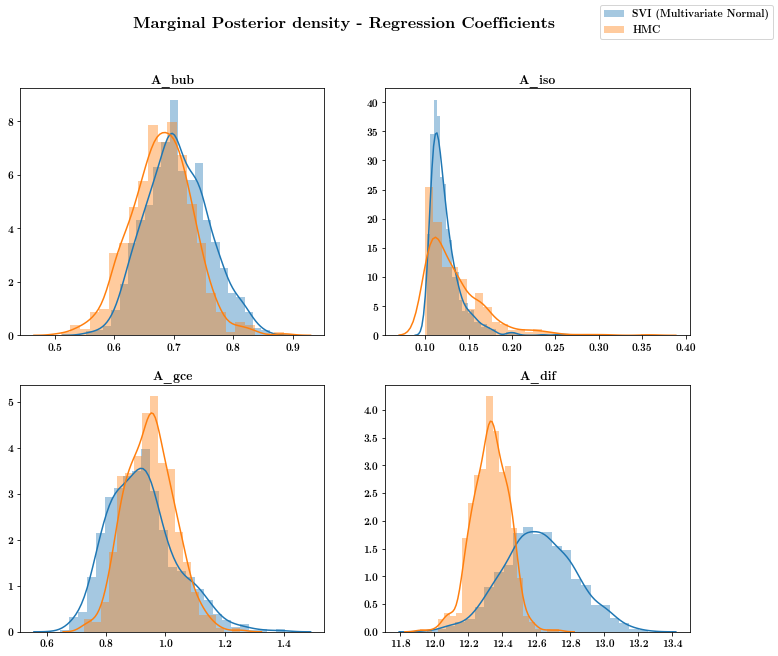

In [36]:
sites = ["A_bub", "A_iso", "A_gce", "A_dif"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [20]:
torch.exp(torch.lgamma(torch.tensor(40.)))

tensor(inf)

In [21]:
torch.tensor(1e40)

tensor(inf)